In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras import backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt

In [29]:
print(tf.__path__)

['c:\\Users\\Kleber\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\keras\\api\\_v2', 'c:\\Users\\Kleber\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\keras\\_tf_keras', 'c:\\Users\\Kleber\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\tensorflow', 'c:\\Users\\Kleber\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\tensorflow\\_api\\v2']


In [30]:
fake = Faker()
Faker.seed(12345)
random.seed(12345)


FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']


LOCALES = ['en_US']

In [31]:
def load_date():
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') 
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [32]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 45445.82it/s]


In [33]:
def softmax(x, axis=1):
    ndim = tf.keras.backend.ndim(x)
    if ndim == 2:
        return tf.keras.backend.softmax(x)
    elif ndim > 2:
        e = tf.keras.backend.exp(x - tf.keras.backend.max(x, axis=axis, keepdims=True))
        s = tf.keras.backend.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [34]:
dataset[:20]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('monday august 19 2024', '2024-08-19'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('22 may 1988', '1988-05-22'),
 ('8 jul 2008', '2008-07-08'),
 ('wednesday september 8 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22'),
 ('16 jun 1978', '1978-06-16'),
 ('friday june 18 1999', '1999-06-18'),
 ('8 october 1987', '1987-10-08'),
 ('1 april 2008', '2008-04-01'),
 ('thursday september 6 2012', '2012-09-06'),
 ('12 11 81', '1981-11-12'),
 ('19 august 2011', '2011-08-19'),
 ('saturday august 25 2007', '2007-08-25')]

In [35]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

In [36]:
def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep

In [37]:
def int_to_string(ints, inv_vocab):
    
    l = [inv_vocab[i] for i in ints]
    return l


In [38]:
Tx = 30
Ty = 10
X, Y, X_oh, Y_oh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", X_oh.shape)
print("Yoh.shape:", Y_oh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [39]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", X_oh[index])
print("Target after preprocessing (one-hot):", Y_oh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [40]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [41]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    return context

In [42]:
n_a = 32 
n_s = 64 
post_activation_LSTM_cell = LSTM(n_s, return_state = True) 
output_layer = Dense(len(machine_vocab), activation=softmax)

In [43]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)
    
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    return model

In [44]:
model_2 = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [45]:
model_2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 64)    │     17,920 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm_2[0][0],     │
│                     │                   │            │ lstm_2[1][0],     │
│                     │                   │            │ lstm_2[2][0],     │
│                     │                   │            │ lstm_2[3][0],     │
│                     │                   │            │ lstm_2[4][0],     │
│                     │                   │            │ lstm_2[5][0],     │
│                     │                   │            │ lstm_2[6][0],     │
│                     │                   │            │ lstm_2[7][0],     │
│                     │                   │            │ lstm_2[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 30, 128)   │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 10)    │      1,290 │ concatenate_1[0]… │
│                     │                   │            │ concatenate_1[1]… │
│                     │                   │            │ concatenate_1[2]… │
│                     │                   │            │ concatenate_1[3]… │
│                     │                   │            │ concatenate_1[4]… │
│                     │                   │            │ concatenate_1[5]… │
│                     │                   │            │ concatenate_1[6]… │
│                     │                   │            │ concatenate_1[7]… │
│                     │                   │            │ concatenate_1[8]

 Total params: 52,960 (206.88 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
opt_2 = Adam(learning_rate=.005, beta_1=.9, beta_2=.999, decay=.01)
model_2.compile(optimizer=opt_2, loss='categorical_crossentropy', metrics=['accuracy']*10)

c:\Users\Kleber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [47]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y_oh.swapaxes(0,1))

In [48]:
model_2.fit([X_oh, s0, c0], outputs, epochs=50, batch_size=100)

Epoch 1/50


c:\Users\Kleber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_557', 's0', 'c0']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - dense_5_accuracy: 0.2061 - dense_5_accuracy_1: 0.4862 - dense_5_accuracy_2: 0.2012 - dense_5_accuracy_3: 0.0736 - dense_5_accuracy_4: 0.7844 - dense_5_accuracy_5: 0.1256 - dense_5_accuracy_6: 0.0266 - dense_5_accuracy_7: 0.7842 - dense_5_accuracy_8: 0.1544 - dense_5_accuracy_9: 0.0769 - dense_5_loss: 2.6626 - loss: 19.8039
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - dense_5_accuracy: 0.9639 - dense_5_accuracy_1: 0.9641 - dense_5_accuracy_2: 0.5079 - dense_5_accuracy_3: 0.2410 - dense_5_accuracy_4: 1.0000 - dense_5_accuracy_5: 0.9126 - dense_5_accuracy_6: 0.3895 - dense_5_accuracy_7: 0.9998 - dense_5_accuracy_8: 0.5452 - dense_5_accuracy_9: 0.2302 - dense_5_loss: 2.0896 - loss: 8.6271
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - dense_5_accuracy: 0.9743 - dense_5_accuracy_1: 0.9723 - dense_5_accuracy_2: 0.6544 - dense_5_accuracy_3: 0.4535 - dense_5_accuracy_4: 0.9999 - dense_5_accuracy_5: 0.9617 - dense_5_accuracy_6: 0.57

In [49]:
def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    layer = modelx.get_layer('attention_weights')

    Ty, Tx = attention_map.shape
    
    human_vocab_size = 37
    
    # Well, this is cumbersome but this version of tensorflow-keras has a bug that affects the 
    # reuse of layers in a model with the functional API. 
    # So, I have to recreate the model based on the functional 
    # components and connect then one by one.
    # ideally it can be done simply like this:
    # layer = modelx.layers[num]
    # f = Model(modelx.inputs, [layer.get_output_at(t) for t in range(Ty)])
    #
    
    X = modelx.inputs[0] 
    s0 = modelx.inputs[1] 
    c0 = modelx.inputs[2] 
    s = s0
    c = s0
    
    a = modelx.layers[2](X)  
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev]) 
        e = modelx.layers[5](concat) 
        energies = modelx.layers[6](e) 
        alphas = modelx.layers[7](energies) 
        context = modelx.layers[8]([alphas, a])
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = modelx.layers[10](context, initial_state = [s, c]) 
        outputs.append(energies)

    f = Model(inputs=[X, s0, c0], outputs = outputs)
    

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    
    r = f([encoded, s0, c0])
        
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = modelx.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\Kleber\AppData\Local\Temp\ipykernel_53692\375079403.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


<Figure size 640x480 with 0 Axes>

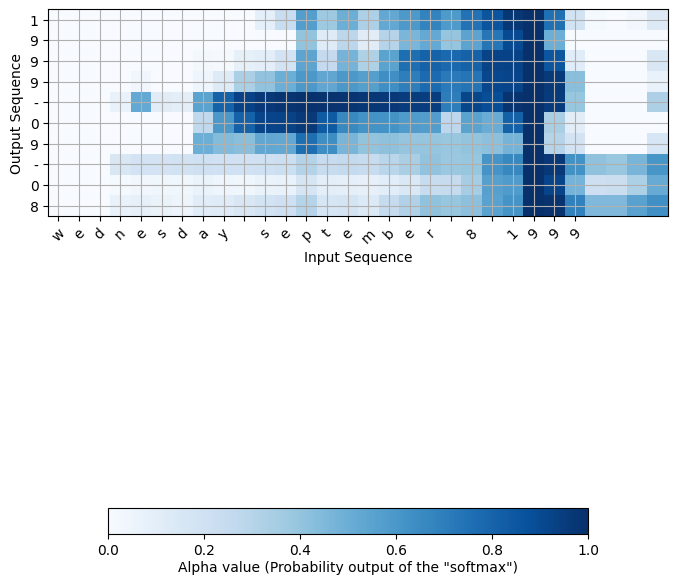

In [50]:
attention_map = plot_attention_map(model_2, human_vocab, inv_machine_vocab, "wednesday september 8 1999", num = 7, n_s = 64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\Kleber\AppData\Local\Temp\ipykernel_53692\375079403.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


<Figure size 640x480 with 0 Axes>

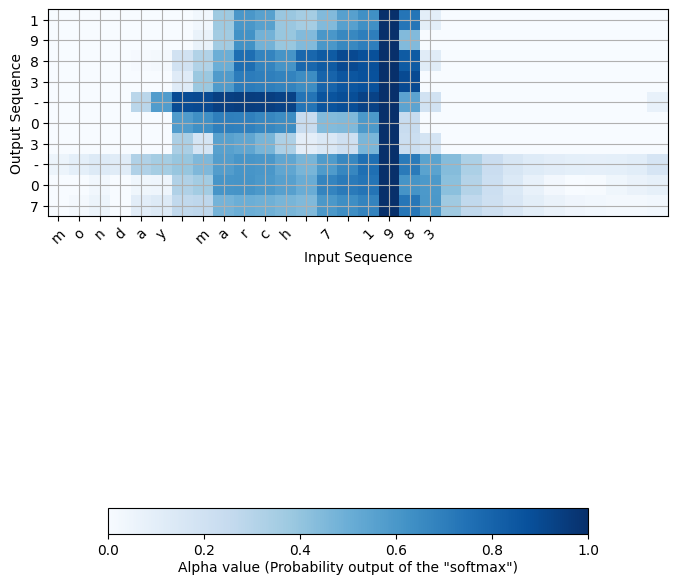

In [51]:
attention_map = plot_attention_map(model_2, human_vocab, inv_machine_vocab, "monday march 7 1983", num = 7, n_s = 64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Users\Kleber\AppData\Local\Temp\ipykernel_53692\375079403.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


<Figure size 640x480 with 0 Axes>

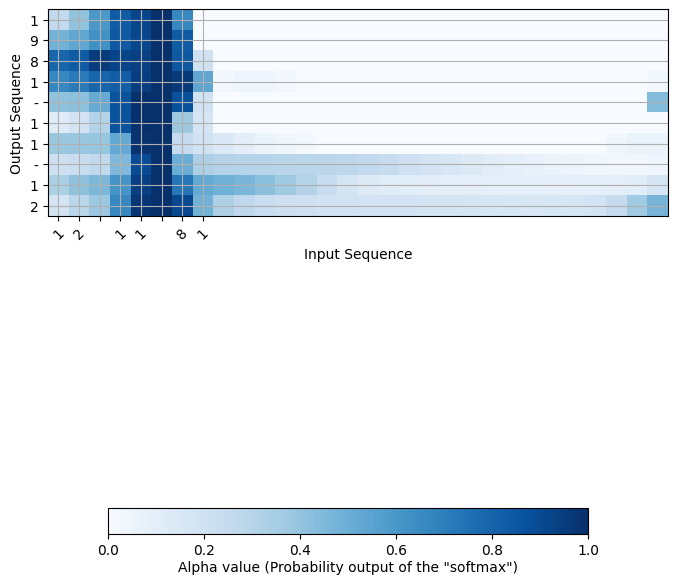

In [52]:
attention_map = plot_attention_map(model_2, human_vocab, inv_machine_vocab, "12 11 81", num = 7, n_s = 64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\Kleber\AppData\Local\Temp\ipykernel_53692\375079403.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


<Figure size 640x480 with 0 Axes>

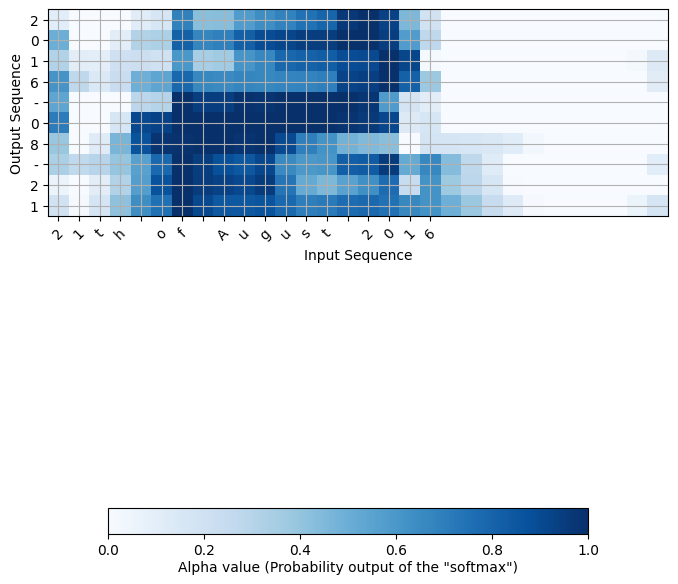

In [53]:
attention_map = plot_attention_map(model_2, human_vocab, inv_machine_vocab, "21th of August 2016", num = 7, n_s = 64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\Kleber\AppData\Local\Temp\ipykernel_53692\375079403.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_text.append(int(np.argmax(prediction[i], axis=1)))


<Figure size 640x480 with 0 Axes>

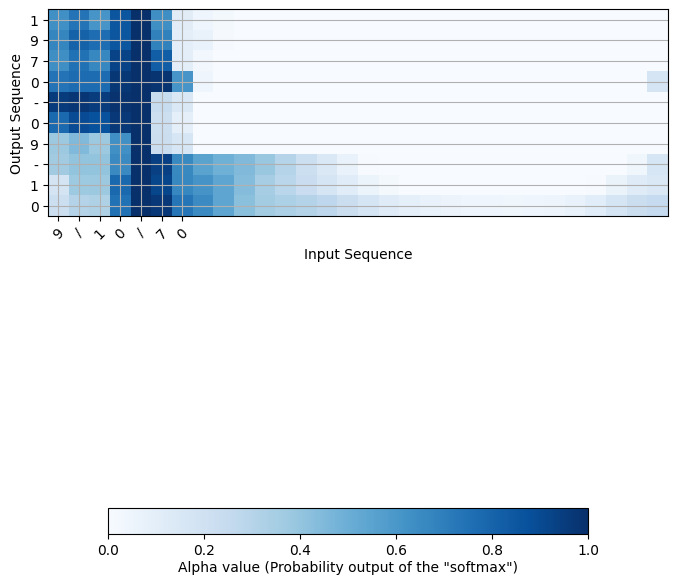

In [54]:
attention_map = plot_attention_map(model_2, human_vocab, inv_machine_vocab, "9/10/70", num = 7, n_s = 64)